# Non-linear Regression Visualization (Polynomial Basis + Exponential)
We model a non-linear relationship using polynomial regression and compare it with a linear baseline and an exponential regression. Includes train/test split, fitted curves, residuals, MSE, **and a short lesson on correlation analysis**.

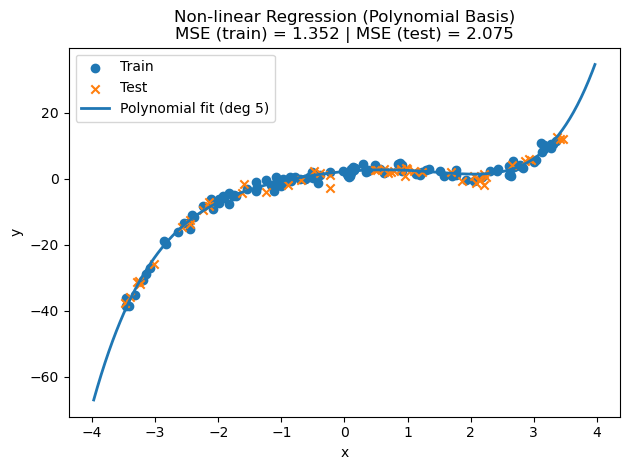

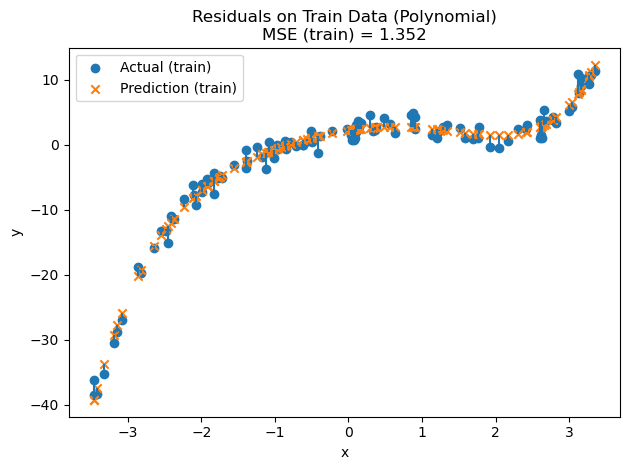

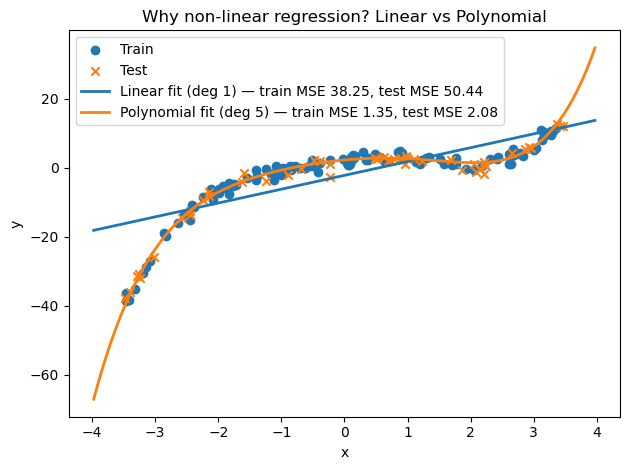

,x,y (actual),y_hat_poly,error_poly,squared_error_poly
0,-3.463748,-36.165558,-39.256794,3.091236,9.555741
1,-3.463143,-38.462604,-39.231268,0.768664,0.590844
2,-3.417442,-38.406449,-37.346381,-1.060068,1.123744
3,-3.323622,-35.225473,-33.733284,-1.492189,2.226629
4,-3.192406,-30.512636,-29.214907,-1.297729,1.684100
5,-3.145072,-28.828325,-27.726134,-1.102191,1.214824
6,-3.085239,-26.889087,-25.943840,-0.945247,0.893492
7,-2.859531,-18.784762,-20.123895,1.339133,1.793277
8,-2.823071,-19.683086,-19.304604,-0.378482,0.143249
9,-2.639755,-15.944418,-15.624387,-0.320031,0.102420


In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# 1) Synthetic non-linear dataset
rng = np.random.default_rng(7)
n = 160
X = rng.uniform(-3.5, 3.5, size=n)
def f(x):
    return 0.6*x**3 - 1.2*x**2 + 1.5*np.sin(2*x) + 2.0
y_true = f(X)
noise = rng.normal(0, 1.2, size=n)
y = y_true + noise

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, test_size=0.3, random_state=0)

# 3) Polynomial regression (degree=5)
degree = 5
poly_model = Pipeline([
    ("poly", PolynomialFeatures(degree=degree, include_bias=True)),
    ("lin", LinearRegression())
])
poly_model.fit(X_train, y_train)

def poly_predict(x):
    return poly_model.predict(x.reshape(-1,1))

y_train_pred_poly = poly_predict(X_train.ravel())
y_test_pred_poly  = poly_predict(X_test.ravel())

mse_train_poly = float(np.mean((y_train - y_train_pred_poly) ** 2))
mse_test_poly  = float(np.mean((y_test  - y_test_pred_poly)  ** 2))

# 4) Fitted polynomial curve visualization
xx = np.linspace(X.min()-0.5, X.max()+0.5, 400)
yy_poly = poly_predict(xx)

fig1 = plt.figure()
plt.scatter(X_train, y_train, label="Train")
plt.scatter(X_test, y_test, marker="x", label="Test")
plt.plot(xx, yy_poly, linewidth=2, label=f"Polynomial fit (deg {degree})")
plt.title(f"Non-linear Regression (Polynomial Basis)\nMSE (train) = {mse_train_poly:.3f} | MSE (test) = {mse_test_poly:.3f}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

# 5) Residuals for polynomial on TRAIN
fig2 = plt.figure()
X_train_flat = X_train.ravel()
plt.vlines(X_train_flat, y_train_pred_poly, y_train)
plt.scatter(X_train_flat, y_train, label="Actual (train)")
plt.scatter(X_train_flat, y_train_pred_poly, marker="x", label="Prediction (train)")
plt.title(f"Residuals on Train Data (Polynomial)\nMSE (train) = {mse_train_poly:.3f}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

# 6) Linear baseline
lin_model = Pipeline([("poly", PolynomialFeatures(degree=1, include_bias=True)), ("lin", LinearRegression())])
lin_model.fit(X_train, y_train)
yy_lin = lin_model.predict(xx.reshape(-1,1))
mse_train_lin = float(np.mean((y_train - lin_model.predict(X_train)) ** 2))
mse_test_lin  = float(np.mean((y_test  - lin_model.predict(X_test))  ** 2))

fig3 = plt.figure()
plt.scatter(X_train, y_train, label="Train")
plt.scatter(X_test, y_test, marker="x", label="Test")
plt.plot(xx, yy_lin, linewidth=2, label=f"Linear fit (deg 1) — train MSE {mse_train_lin:.2f}, test MSE {mse_test_lin:.2f}")
plt.plot(xx, yy_poly, linewidth=2, label=f"Polynomial fit (deg {degree}) — train MSE {mse_train_poly:.2f}, test MSE {mse_test_poly:.2f}")
plt.title("Why non-linear regression? Linear vs Polynomial")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

# 7) Per-point loss table (polynomial, first 12 train samples)
order = np.argsort(X_train_flat)
firstk = order[:12]
df_explain_poly = pd.DataFrame({
    "x": X_train_flat[firstk],
    "y (actual)": y_train[firstk],
    "y_hat_poly": y_train_pred_poly[firstk],
})
df_explain_poly["error_poly"] = df_explain_poly["y (actual)"] - df_explain_poly["y_hat_poly"]
df_explain_poly["squared_error_poly"] = df_explain_poly["error_poly"] ** 2
df_explain_poly.reset_index(drop=True, inplace=True)
df_explain_poly


## Add Exponential Regression
We compare with an exponential model $ y = a e^{b x} $. Because our data can be negative, we fit on a **shifted** target to ensure positivity and then shift predictions back:
- Let $ s = \min(y_{\text{train}}) - \epsilon $ with $ \epsilon = 1.0 $.
- Fit a linear regression to \( \ln(y - s) = \ln a + b x \) on the training set.
- Predict $ \hat{y} = a e^{b x} + s $.

In [26]:

# 8) Exponential regression: y = a * exp(b x), via log-transform on shifted targets
eps = 1.0
shift = float(np.min(y_train) - eps)  # shift based on train min to avoid leakage
y_train_shift = y_train - shift
mask_pos = y_train_shift > 0  # ensure positivity

# Use only positive-shifted points to fit log
X_fit = X_train[mask_pos]
y_fit_log = np.log(y_train_shift[mask_pos])

# Fit log-linear: log(y - shift) = log(a) + b x
lin_for_exp = LinearRegression().fit(X_fit, y_fit_log)
log_a = lin_for_exp.intercept_
b = lin_for_exp.coef_[0]
a = float(np.exp(log_a))

def exp_predict(x):
    x = np.asarray(x).reshape(-1,1)
    y_hat_shift = a * np.exp(b * x)
    return (y_hat_shift + shift).ravel()

# Predictions and MSE
y_train_pred_exp = exp_predict(X_train.ravel())
y_test_pred_exp  = exp_predict(X_test.ravel())
mse_train_exp = float(np.mean((y_train - y_train_pred_exp) ** 2))
mse_test_exp  = float(np.mean((y_test  - y_test_pred_exp)  ** 2))

# Show parameters
a, b, shift, mse_train_exp, mse_test_exp


(33.61726477279074,
 np.float64(0.1844453389396079),
 -39.462603981867694,
 89.01480515334522,
 79.812337935139)

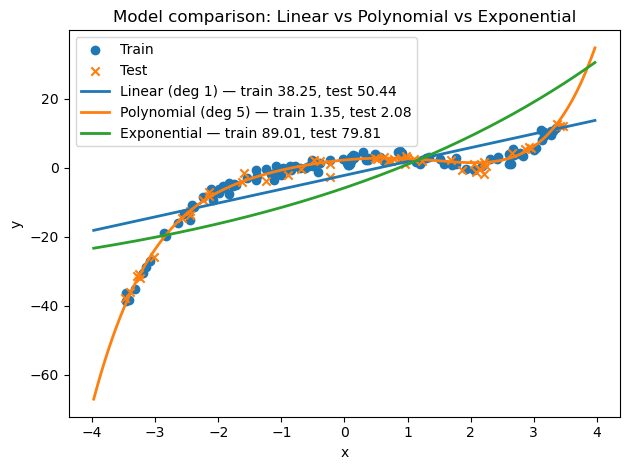

In [28]:

# 9) Visualize polynomial vs exponential vs linear
yy_exp = exp_predict(xx)

fig4 = plt.figure()
plt.scatter(X_train, y_train, label="Train")
plt.scatter(X_test, y_test, marker="x", label="Test")
plt.plot(xx, yy_lin, linewidth=2, label=f"Linear (deg 1) — train {mse_train_lin:.2f}, test {mse_test_lin:.2f}")
plt.plot(xx, yy_poly, linewidth=2, label=f"Polynomial (deg {degree}) — train {mse_train_poly:.2f}, test {mse_test_poly:.2f}")
plt.plot(xx, yy_exp, linewidth=2, label=f"Exponential — train {mse_train_exp:.2f}, test {mse_test_exp:.2f}")
plt.title("Model comparison: Linear vs Polynomial vs Exponential")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()


## Short Lesson: Correlation Analysis
**Goal:** quantify how strongly variables move together.

**Pearson correlation (r):** measures *linear* association between two numeric variables.

$ r = \frac{\sum_i (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_i (x_i - \bar{x})^2} \, \sqrt{\sum_i (y_i - \bar{y})^2}} $

**Interpretation (rough guide):**
- |r| < 0.2: very weak; 0.2–0.4: weak; 0.4–0.6: moderate; 0.6–0.8: strong; > 0.8: very strong.

**Spearman rank correlation (ρ):** captures *monotonic* (not necessarily linear) relationships by applying Pearson to the ranks.

**Caveats:** correlation ≠ causation; outliers and non-linearity can distort Pearson; highly correlated features can cause multicollinearity in regression.

**Practice in this notebook:**
1) Pearson r between raw x and y on the training set.
2) Correlation matrix between polynomial features (x, x², …, x⁵) and y.
3) Heatmap for quick visual inspection.

In [31]:

# 10) Pearson correlation: x vs y (train)
x_train_series = pd.Series(X_train.ravel(), name="x")
y_train_series = pd.Series(y_train, name="y")
pearson_xy = float(np.corrcoef(x_train_series, y_train_series)[0,1])
pearson_xy


0.7857008419323119

In [33]:

# 11) Correlation matrix among polynomial features and y (train set)
poly_feat = PolynomialFeatures(degree=5, include_bias=False)
Phi_train = poly_feat.fit_transform(X_train)  # columns: x, x^2, ..., x^5
feature_names = poly_feat.get_feature_names_out(["x"])

df_corr = pd.DataFrame(Phi_train, columns=feature_names)
df_corr["y"] = y_train
corr_matrix = df_corr.corr()

# Display a compact table of correlations with y
corr_with_y = corr_matrix.loc[feature_names, "y"].to_frame("corr_with_y").sort_values("corr_with_y", ascending=False)
corr_with_y


,corr_with_y
x^5,0.884336
x^3,0.876491
x,0.785701
x^2,-0.380321
x^4,-0.391175


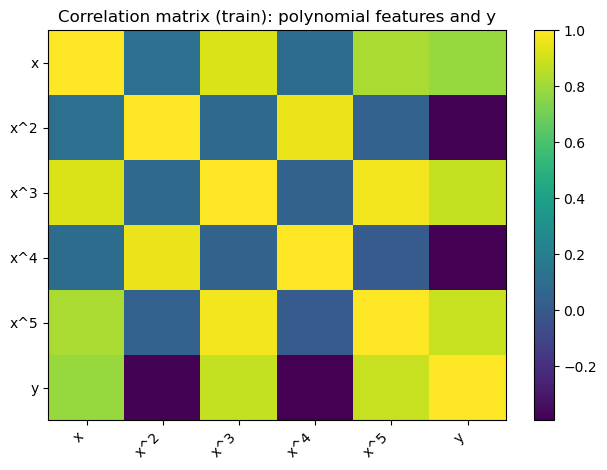

In [35]:

# 12) Heatmap of the full correlation matrix
fig = plt.figure()
plt.imshow(corr_matrix, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha="right")
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Correlation matrix (train): polynomial features and y")
plt.tight_layout()
plt.show()
